In [1]:
from collections import Counter
import string
import nltk
nltk.download('punkt')
nltk.download('words')
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from nltk.corpus import words
import multiprocessing

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Arian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Arian\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
# TODO: Change the paths and the names of the files you want to create word clouds for
NEWS = {
  "path": "./news/news.txt",
  "name": "news"
}
BIBLE = {
  "path": "./bible/preprocessed/preprocessed_text.txt",
  "name": "bible"
}
WIKI_TL = {
  "path": "./wiki_tl/preprocessed_wiki_tl.txt",
  "name": "wiki tagalog"
}
HISTORICAL= {
    "path": "./historical/hist-preprocessed.txt",
    "name": "historical"
}
SONGS={
    "path": "./songs/preprocessed.txt",
    "name": "songs"
}

dataset = [NEWS, BIBLE, WIKI_TL, HISTORICAL, SONGS]

In [3]:
english_words = set(words.words())

def filter_word(word: str, english_words: set, tagalog_words: set) -> str:
    """
    Filter out single letter words except "o" and English words. 
    Retain words that are found in the tagalog_words set.
    """
    if word in english_words:
        if word in tagalog_words:
            # print(word)
            return word
    else:
        return word

def preprocess_text(text: str, tagalog_words: set) -> List[str]:
    """
    Preprocesses input text by removing single letter words except "o", removing English words, and
    converting all characters to lowercase. 
    Retain words that are found in the tagalog_words set.
    """
    # Remove punctuation and convert to lowercase
    # text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    
    # Tokenize the text into individual words
    words = text.lower().split()
    
    # Filter out single-letter words except "o" and English words
    # Use multiprocessing to speed up the filtering process
    preprocessed_words = [filter_word(word, english_words, tagalog_words) for word in words]
    # with multiprocessing.Pool(16) as pool:
    #     preprocessed_words = pool.starmap(filter_word, [(word, english_words, tagalog_words) for word in words])
    
    # Filter out empty strings
    preprocessed_words = list(filter(None, preprocessed_words))
    
    return preprocessed_words



In [4]:
# input_text = 'Ano ba ang ginagawa ng mga taong ito - This is a sample sentence in Tagalog with some English words like apple and banana.'
with open('./tagalog-dictionary-scraper/tagalog_dict.txt', 'r', encoding='utf-8') as f:
        tagalog_words = list(set([line.strip() for line in f]))
        
# preprocess_text(input_text, tagalog_words)

In [5]:
from concurrent.futures import ThreadPoolExecutor

def get_ngrams(filename:str, ngram_sizes:List[int]) -> Dict[int, Dict[str, int]]:
    """
    This function computes the n-grams for the given input file and the specified n-gram sizes. This function assumes that the input text has been preprocessed already. 

    Parameters
    ----------
    filename : str
        The input file to process.
    ngram_sizes : List[int]
        The list of n-gram sizes to generate.

    Returns
    -------
    all_ngrams : Dict[int, Dict[str, int]]
        A dictionary of n-grams, where the key is the n-gram size, and the value is a dictionary containing
        n-grams as keys and their count as values.
    
    Examples
    --------
    >>> all_ngrams = get_ngrams("input.txt", [2, 3])
    >>> all_ngrams
    {
        2: {'Walang nakahula': 11, 'nakahula sa': 11, 'sa mga': 214, 'mga panalong': 11},
        3: {'Walang nakahula sa': 11, 'nakahula sa mga': 11, 'sa mga panalong': 11}
    }
    """
    with open(filename, "r", encoding="cp1252") as f:
        text:str = f.read()
    # words:List[str] = text.lower().split()
    words:List[str] =preprocess_text(text,tagalog_words) 
    all_ngrams:Dict[int, Dict[str, int]] = {}
    
    def generate_ngrams_worker(words: List[str], ngram_size: int) -> List[Tuple[str]]:
        ngrams = []
        for i in range(len(words) - ngram_size + 1):
            ngram = tuple(words[i:i+ngram_size])
            ngrams.append(ngram)
        return ngrams
    
    num_workers: int = 16
    
    for ngram_size in ngram_sizes:
        ngrams = []
        chunk_size = (len(words) + num_workers - 1) // num_workers
        chunks = [words[i:i + chunk_size] for i in range(0, len(words), chunk_size)]
        
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            futures = [executor.submit(generate_ngrams_worker, chunk, ngram_size) for chunk in chunks]
            for future in futures:
                ngrams.extend(future.result())
        all_ngrams[ngram_size] = dict([(" ".join(k), v) for k, v in Counter(ngrams).items()])
        
    return all_ngrams



In [6]:
def get_most_common_ngrams(all_ngrams: Dict[int, List[Tuple[str, int]]], n: int) -> Dict[int, List[Tuple[str, int]]]:
    most_common_ngrams = {}
    for ngram_size, ngrams in all_ngrams.items():
        most_common_ngrams[ngram_size] = dict(sorted(ngrams.items(), key=lambda x: x[1], reverse=True)[:n])
    return most_common_ngrams

In [7]:
ngrams_names = {2: "bigrams", 3: "trigrams", 4: "quadgrams", 5: "pentagrams", 6: "hexagrams", 7: "heptagrams", 8: "octagrams", 9: "nonagrams", 10: "decagrams"}


def display_ngram(ngram_size, ngram, source):
   

   labels = list(ngram.keys())
   values = list(ngram.values())
   indexes = range(len(labels))

   plt.barh(indexes, values, align='center')

   plt.yticks(indexes, labels)

   plt.ylabel(ngrams_names[ngram_size])

   plt.xlabel("Frequency")

   plt.title(f"{source} {ngrams_names[ngram_size]}")

   plt.gca().invert_yaxis()
   plt.show() 

In [8]:
def extend_dict(dict1, dict2):
   for i in dict1.keys():
      for key, value in dict2[i].items():
         if key in dict1[i].keys():
            dict1[i][key]+=value
         else:
            dict1[i][key] = value

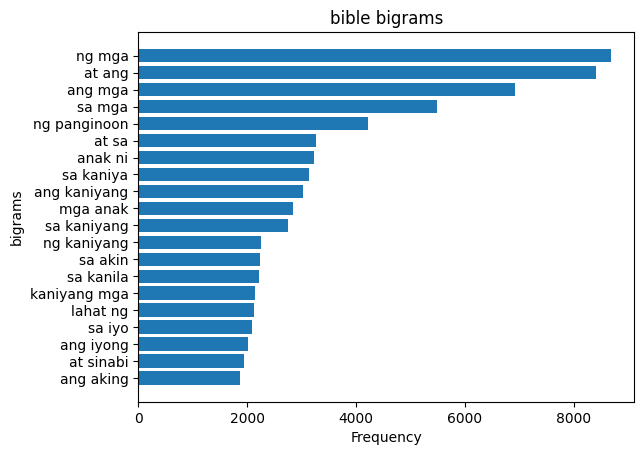

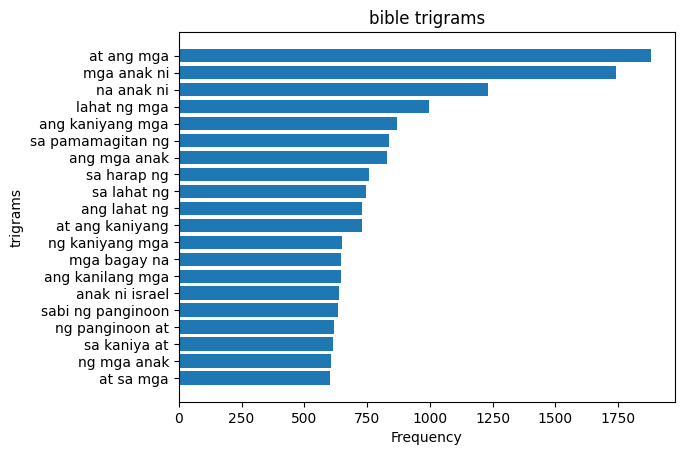

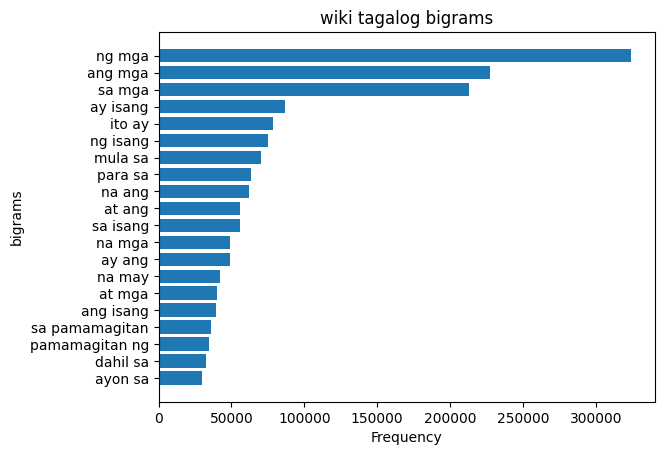

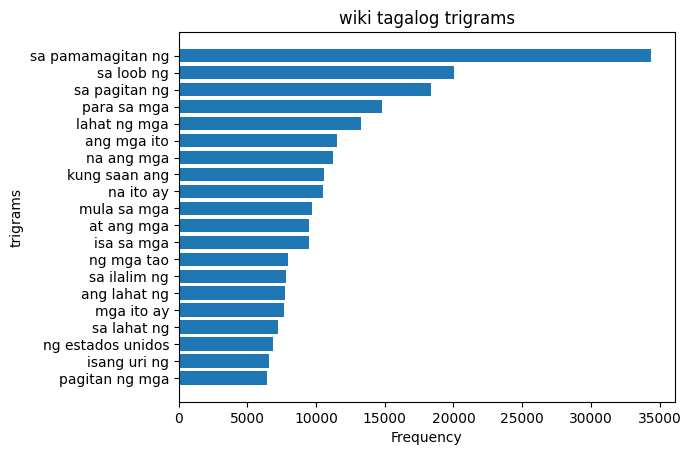

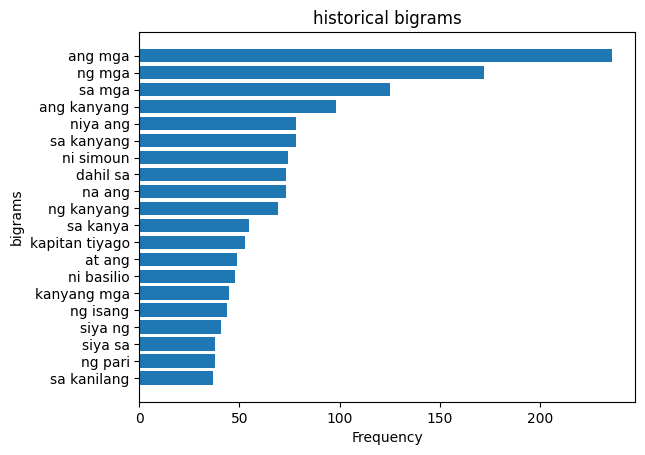

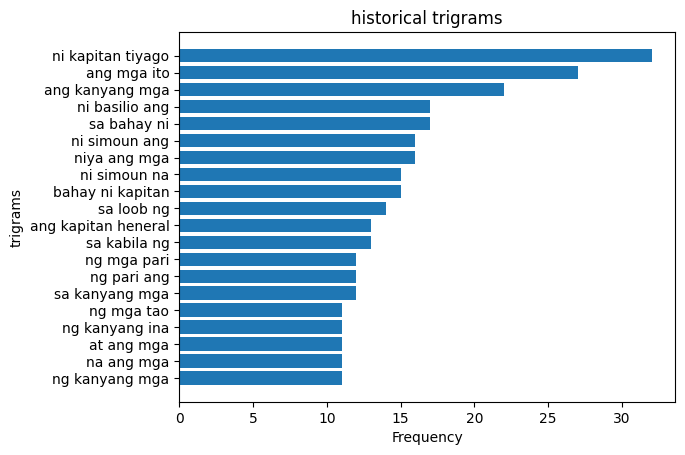

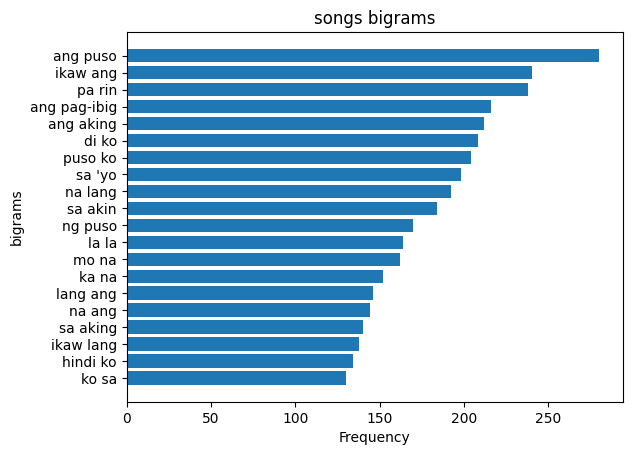

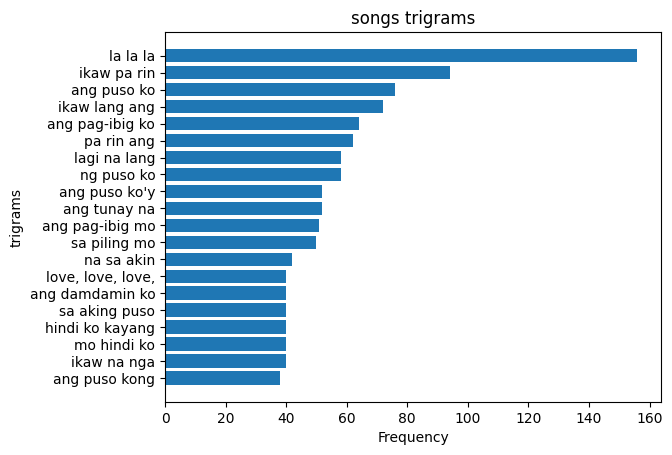

In [9]:
ngram_sizes =  [2,3] # Bigram and Trigram

ngrams_compilation = {}
for source in dataset:
   ngrams = get_ngrams(source["path"], ngram_sizes)
   if len(ngrams_compilation)<=0:
      ngrams_compilation  = ngrams
      continue
   extend_dict(ngrams_compilation, ngrams)
   
   top_ngrams = get_most_common_ngrams(ngrams,20)
   for i, ngram in enumerate(ngrams):
      display_ngram(ngram_size=ngram_sizes[i], ngram=top_ngrams[ngram_sizes[i]], source=source["name"])  
   

In [10]:
ngrams_compilation

{2: {'walang nakahula': 11,
  'nakahula sa': 11,
  'sa mga': 218860,
  'mga panalong': 11,
  'panalong kumbinasyon': 11,
  'kumbinasyon para': 16,
  'para sa': 63710,
  'sa at': 4332,
  'at mega': 14,
  'mega sa': 12,
  'sa ng': 4256,
  'ng philippine': 728,
  'philippine sweepstakes': 14,
  'sweepstakes pcso': 13,
  'pcso nitong': 11,
  'nitong peb': 11,
  'peb ang': 13,
  'ang masuwerteng': 11,
  'masuwerteng numero': 11,
  'numero para': 14,
  'sa ay': 4071,
  'ay para': 1054,
  'sa jackpot': 22,
  'jackpot na': 25,
  'na nagkakahalaga': 159,
  'nagkakahalaga ng': 328,
  'ng gayunpaman': 110,
  'gayunpaman limang': 11,
  'limang manlalaro': 20,
  'manlalaro ang': 316,
  'ang nanalo': 139,
  'nanalo sa': 568,
  'sa ikalawang': 1388,
  'ikalawang gantimpala': 49,
  'gantimpala na': 96,
  'ng at': 8785,
  'at na': 2775,
  'na taya': 75,
  'taya ang': 12,
  'ang tumama': 24,
  'tumama sa': 416,
  'sa ikatlong': 668,
  'ikatlong gantimpala': 26,
  'ng ang': 9334,
  'ang ay': 10793,
  'ay

In [16]:
type(ngrams_compilation[2])

dict

In [ ]:
from typing import Dict, List, Tuple
import pandas as pd

def write_ngrams_to_csv(ngrams_compilation: Dict[int, Dict[str, int]]) -> None:
    for n in ngrams_compilation.keys():
        ngram_name = ngrams_names[n]
        sorted_ngram = dict(sorted(ngrams_compilation[n].items(), key=lambda x: x[1], reverse=True))
        
        df = pd.DataFrame(sorted_ngram.items(), columns=[ngram_name,f"{ngram_name} frequency"])
        df.to_csv(f"{ngram_name}.csv", index=False)
            

write_ngrams_to_csv(ngrams_compilation)